<a href="https://colab.research.google.com/github/rurusasu/RecommendSystem/blob/main/TowTowerRecommendModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自作データセットで TowTowerRecommendModel を試験する
参考:
* [1つの Two-Tower モデルで4種類の推薦を実現する](https://qiita.com/rayuron/items/cc04468de7af3d82bac2)
* [Two-Tower Recommendationについて](https://qiita.com/akira_saigo/items/fb07c970febc872d22e3)

データセット: MovieLens-100k

In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_dir = "/content/drive/MyDrive/ColabNotebooks"

In [3]:
!pip install  --upgrade -q tensorflow_recommenders tensorflow-datasets apache-beam

In [4]:
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.style.use("seaborn-whitegrid")

<ipython-input-4-4ae0939fc385>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# データセットの読み出しと前処理

In [5]:
base_dir = "/content/drive/MyDrive/Google AI Studio"

In [6]:
# エクセルファイルからデータを読み込む
data = pd.read_excel(f"{base_dir}/sample_merged_full_10k.xlsx")

data.head(2)

,user_id,target_id,rating,user_name_target,nickname_target,gender_target,location_target,age_range_target,height_range_target,body_type_target,...,body_type_user,personality_user,appearance_user,job_user,blood_type_user,car_user,interests_user,salary_user,plan_user,account_creation_timestamp_user
0,1,8627,0,原田遥,アオイ,女性,埼玉県伊奈町,45-49,150-154,普通,...,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000,option2,2024-01-14 00:11:34
1,1,18213,0,井上萌,ユイ,女性,福島県玉川村,30-34,150-154,スリム,...,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000,option2,2024-01-14 00:11:34


In [7]:
from tensorflow.keras.utils import to_categorical

# ラベルに不正な値が含まれている可能性があるので、削除
cleaning_data = data[data['rating'].isin([0, 1, 2])]
cleaning_data = cleaning_data.dropna()

# 不要なカラムの削除
cleaning_data = cleaning_data.drop(columns=['user_id', 'target_id', 'user_name_target', 'nickname_target',
                     'plan_target', 'account_creation_timestamp_target',
                     'user_name_user', 'nickname_user', 'plan_user',
                     'account_creation_timestamp_user'])

# 特徴量とラベルの分離
features = cleaning_data.drop(columns=['rating'])
labels = cleaning_data['rating']
# ラベルをOne-Hotエンコーディング
#labels = to_categorical(labels, num_classes=3)

# データの確認
features.head(2)

,gender_target,location_target,age_range_target,height_range_target,body_type_target,personality_target,appearance_target,job_target,blood_type_target,car_target,...,age_range_user,height_range_user,body_type_user,personality_user,appearance_user,job_user,blood_type_user,car_user,interests_user,salary_user
0,女性,埼玉県伊奈町,45-49,150-154,普通,面白い,-,会社員,A型,無し,...,22-25,175-179,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000
1,女性,福島県玉川村,30-34,150-154,スリム,明るい,セクシー系,会社員,A型,無し,...,22-25,175-179,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000


In [8]:
# データをTensorflow Datasetに変換
dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

# データセットを訓練データと検証データに分割
dataset_size = len(features)
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# モデルの訓練に適したようにデータセットをバッチ化
train_dataset = train_dataset.batch(128)
val_dataset = val_dataset.batch(128)

# モデル定義

### UserModel

In [9]:
# interests カラムの処理 (Multi-hot Encoding)
#all_interests = []
#for interests_str in data['interests_user']:
#  all_interests.extend(interests_str.split(', '))
#user_interest_vocab = sorted(set(all_interests))

import tensorflow as tf

# UserModelの定義
class UserModel(tf.keras.Model):
    def __init__(self, embedding_dims: dict, features: pd.DataFrame):
        super(UserModel, self).__init__()
        self.embedding_dims = embedding_dims
        self.embedding_layers = {}
        self.interest_embedding = None
        self.salary_embedding_layer = None

        for feature_name in self.embedding_dims:
            if features[feature_name].dtype == 'object' and feature_name != 'interests_user':
                vocab = sorted(list(set(features[feature_name].values)))
                self.embedding_layers[feature_name] = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='int'),
                    tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.embedding_dims[feature_name])
                ])
            if features[feature_name].dtype == 'object' and feature_name == 'interests_user':
                all_interests = []
                for interests_str in data['interests_user']:
                    all_interests.extend(interests_str.split(', '))
                interest_vocab = sorted(set(all_interests))

                self.interest_embedding = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=interest_vocab, output_mode='multi_hot'),
                    tf.keras.layers.Dense(units=self.embedding_dims['interests_user'], activation='relu')
                ])

        self.salary_embedding_layer = tf.keras.layers.Dense(units=self.embedding_dims['salary_user'], activation='relu')

    def call(self, inputs: dict) -> tf.Tensor:
        embeddings = []
        for feature_name in self.embedding_dims:
            if feature_name in self.embedding_layers:
                embeddings.append(self.embedding_layers[feature_name](inputs[feature_name]))
            elif feature_name == 'interests_user':
                interest_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.interest_embedding(interest_tensor))
            elif feature_name == 'salary_user':
                salary_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.salary_embedding_layer(salary_tensor))

        # 全てのembeddingの形状を最大形状に合わせる
        max_shape = max([embedding.shape[1] for embedding in embeddings])
        embeddings = [tf.pad(embedding, [[0, 0], [0, max_shape - embedding.shape[1]]]) for embedding in embeddings]

        # 全てのembeddingを結合
        #return tf.stack(embeddings, axis=1)
        return tf.reduce_mean(tf.stack(embeddings, axis=1), axis=1)


# UserModelのインスタンス化
embedding_dims = {
        'gender_user': 2,
        'location_user': 10,
        'age_range_user': 5,
        'height_range_user': 5,
        'body_type_user': 8,
        'personality_user': 10,
        'appearance_user': 8,
        'job_user': 15,
        'blood_type_user': 4,
        'car_user': 2,
        'interests_user': 20,
        'salary_user': 10
    }

user_model = UserModel(embedding_dims, features)

### Query Model

In [10]:
# QueryModelの定義
class QueryModel(tf.keras.Model):
    def __init__(self, layer_sizes: list, embedding_dims: dict, features: pd.DataFrame, num_classes: int=3):
        super().__init__()
        self.embedding_model = UserModel(embedding_dims, features)
        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        self.output_layer = tf.keras.layers.Dense(num_classes) # 出力層の次元を指定

    def call(self, inputs: dict) -> tf.Tensor:
        feature_embedding = self.embedding_model(inputs)
        #for dense_layer in self.dense_layers:
        #    feature_embedding = dense_layer(feature_embedding)
        feature_embedding = self.dense_layers(feature_embedding)
        return self.output_layer(feature_embedding) # 出力層を適用

### TargetModel

In [11]:
# TargetModelの定義
class TargetModel(tf.keras.Model):
    def __init__(self, embedding_dims: dict, features: pd.DataFrame):
        super(TargetModel, self).__init__()
        self.embedding_dims = embedding_dims
        self.embedding_layers = {}
        self.interest_embedding = None
        self.salary_embedding_layer = None

        for feature_name in self.embedding_dims:
            if features[feature_name].dtype == 'object' and feature_name != 'interests_target':
                vocab = sorted(list(set(features[feature_name].values)))
                self.embedding_layers[feature_name] = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='int'),
                    tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.embedding_dims[feature_name])
                ])
            if features[feature_name].dtype == 'object' and feature_name == 'interests_target':
                all_interests = []
                for interests_str in data['interests_target']:
                    all_interests.extend(interests_str.split(', '))
                interest_vocab = sorted(set(all_interests))

                self.interest_embedding = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=interest_vocab, output_mode='multi_hot'),
                    tf.keras.layers.Dense(units=self.embedding_dims['interests_target'], activation='relu')
                ])

        self.salary_embedding_layer = tf.keras.layers.Dense(units=self.embedding_dims['salary_target'], activation='relu')

    def call(self, inputs: dict) -> tf.Tensor:
        embeddings = []
        for feature_name in self.embedding_dims:
            if feature_name in self.embedding_layers:
                embeddings.append(self.embedding_layers[feature_name](inputs[feature_name]))
            elif feature_name == 'interests_target':
                interest_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.interest_embedding(interest_tensor))
            elif feature_name == 'salary_target':
                salary_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.salary_embedding_layer(salary_tensor))

        # 全てのembeddingの形状を最大形状に合わせる
        max_shape = max([embedding.shape[1] for embedding in embeddings])
        embeddings = [tf.pad(embedding, [[0, 0], [0, max_shape - embedding.shape[1]]]) for embedding in embeddings]

        # 全てのembeddingを結合
        #return tf.stack(embeddings, axis=1)
        return tf.reduce_mean(tf.stack(embeddings, axis=1), axis=1)


# TargetModelのインスタンス化
embedding_dims = {
        'gender_target': 2,
        'location_target': 10,
        'age_range_target': 5,
        'height_range_target': 5,
        'body_type_target': 8,
        'personality_target': 10,
        'appearance_target': 8,
        'job_target': 15,
        'blood_type_target': 4,
        'car_target': 2,
        'interests_target': 20,
        'salary_target': 10
    }

target_model = TargetModel(embedding_dims, features)

### CandidateModel

In [12]:
# CandidateModelの定義
class CandidateModel(tf.keras.Model):
    def __init__(self, layer_sizes: list, embedding_dims: dict, features: pd.DataFrame, num_classes: int = 3):
        super().__init__()
        self.embedding_model = TargetModel(embedding_dims, features)
        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        self.output_layer = tf.keras.layers.Dense(num_classes) # 出力層の次元を指定

    def call(self, inputs: dict) -> tf.Tensor:
        feature_embedding = self.embedding_model(inputs)
        #for dense_layer in self.dense_layers:
        #    feature_embedding = dense_layer(feature_embedding)
        feature_embedding = self.dense_layers(feature_embedding)
        return self.output_layer(feature_embedding) # 出力層を適用

### TowTowerModel

In [13]:
class TwoTowerModel(tf.keras.Model):
    def __init__(self, layer_size: list, features, num_classes: int = 3):
        super().__init__()
        user_embedding_dims = {
            'gender_user': 2,
            'location_user': 10,
            'age_range_user': 5,
            'height_range_user': 5,
            'body_type_user': 8,
            'personality_user': 10,
            'appearance_user': 8,
            'job_user': 15,
            'blood_type_user': 4,
            'car_user': 2,
            'interests_user': 20,
            'salary_user': 10
        }
        target_embedding_dims = {
            'gender_target': 2,
            'location_target': 10,
            'age_range_target': 5,
            'height_range_target': 5,
            'body_type_target': 8,
            'personality_target': 10,
            'appearance_target': 8,
            'job_target': 15,
            'blood_type_target': 4,
            'car_target': 2,
            'interests_target': 20,
            'salary_target': 10
        }
        self.query_model = QueryModel(layer_size, user_embedding_dims, features=features, num_classes=num_classes)
        self.candidate_model = CandidateModel(layer_size, target_embedding_dims, features=features, num_classes=num_classes)
        # logit_scaleの定義と計算
        self.logit_scale = tf.Variable(1.0, trainable=True)

    def call(self, inputs):
        user_inputs = {key: value for key, value in inputs.items() if key.endswith('_user')}
        target_inputs = {key: value for key, value in inputs.items() if key.endswith('_target')}
        user_embeddings = self.query_model(user_inputs)
        target_embeddings = self.candidate_model(target_inputs)
        logit_scale_exp = tf.exp(self.logit_scale)
        logits = tf.matmul(user_embeddings, target_embeddings, transpose_b=True) * logit_scale_exp
        return logits

### モデル構築テスト

In [14]:
# QueryModelのインスタンスを生成する関数
def create_query_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_user': 2,
        'location_user': 10,
        'age_range_user': 5,
        'height_range_user': 5,
        'body_type_user': 8,
        'personality_user': 10,
        'appearance_user': 8,
        'job_user': 15,
        'blood_type_user': 4,
        'car_user': 2,
        'interests_user': 20,
        'salary_user': 10
    }
    return QueryModel(layer_sizes, embedding_dims, features)

# CandidateModelのインスタンスを生成する関数
def create_candidate_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_target': 2,
        'location_target': 10,
        'age_range_target': 5,
        'height_range_target': 5,
        'body_type_target': 8,
        'personality_target': 10,
        'appearance_target': 8,
        'job_target': 15,
        'blood_type_target': 4,
        'car_target': 2,
        'interests_target': 20,
        'salary_target': 10
    }
    return CandidateModel(layer_sizes, embedding_dims, features)

# テストスクリプト
def test_model(features):
    # モデルの生成
    query_model = create_query_model(features)
    cnadidate_model = create_candidate_model(features)

    # モデルの呼び出し
    for dummy_data, labels in train_dataset.take(1):
        user_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_user')}
        target_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_target')}
        query_output = query_model(user_inputs)
        candidate_output = cnadidate_model(target_inputs)

    # 出力の表示
    print("Model output:")
    print("Query output:", query_output)
    #print("Candidate output:", candidate_output)

# テストの実行
test_model(features)

Model output:
Query output: tf.Tensor(
[[ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 56176.508    4304.7754 -32580.781 ]
 [ 48741.4      3735.0312 -28268.613 ]
 [ 48741.4      3735.0312 -28268.613 ]
 [ 48741.4      3735.0312 -28268.613 ]
 [ 48741.4      3735.0312 -28268.613 ]
 [ 48741.4      3735.0312 -28268.613 ]
 [ 48741.4      3735.0312 -28268.613 ]
 [ 48741.4      3735.0312

In [15]:
# QueryModelのインスタンス生成
def create_query_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_user': 2,
        'location_user': 10,
        'age_range_user': 5,
        'height_range_user': 5,
        'body_type_user': 8,
        'personality_user': 10,
        'appearance_user': 8,
        'job_user': 15,
        'blood_type_user': 4,
        'car_user': 2,
        'interests_user': 20,
        'salary_user': 10
    }
    return QueryModel(layer_sizes, embedding_dims, features)

# テストスクリプト
def test_model(features):
    model = create_query_model(features)
    for dummy_data, labels in train_dataset.take(1):
        user_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_user')}
        print(user_inputs.keys())
        output = model(user_inputs)
        print("Model output:")
        print(output)

# テストの実行
test_model(features)

dict_keys(['gender_user', 'location_user', 'age_range_user', 'height_range_user', 'body_type_user', 'personality_user', 'appearance_user', 'job_user', 'blood_type_user', 'car_user', 'interests_user', 'salary_user'])
Model output:
tf.Tensor(
[[  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  49129.953  -82667.52   127490.73 ]
 [  42627.46   -71726.22   110616.914]
 [  42627.46   -71

In [16]:
# CandidateModelのインスタンスを生成する関数
def create_candidate_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_target': 2,
        'location_target': 10,
        'age_range_target': 5,
        'height_range_target': 5,
        'body_type_target': 8,
        'personality_target': 10,
        'appearance_target': 8,
        'job_target': 15,
        'blood_type_target': 4,
        'car_target': 2,
        'interests_target': 20,
        'salary_target': 10
    }
    return CandidateModel(layer_sizes, embedding_dims, features)

# テストスクリプト
def test_model(features):
    model = create_candidate_model(features)
    for dummy_data, labels in train_dataset.take(1):
        target_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_target')}
        output = model(target_inputs)
        print("Model output:")
        print(output)

# テストの実行
test_model(features)

Model output:
tf.Tensor(
[[ 40359.617 -80207.    -65369.86 ]
 [ 26640.807 -52943.5   -43149.723]
 [ 16559.566 -32908.96  -26821.303]
 [ 11709.479 -23270.355 -18965.684]
 [ 24181.133 -48055.344 -39165.824]
 [ 21790.729 -43304.89  -35294.125]
 [ 28996.55  -57625.11  -46965.32 ]
 [ 24596.85  -48881.508 -39839.164]
 [ 21894.656 -43511.438 -35462.46 ]
 [ 32426.258 -64440.992 -52520.35 ]
 [ 31941.271 -63477.11  -51734.81 ]
 [ 15693.48  -31187.783 -25418.51 ]
 [ 17806.729 -35387.465 -28841.293]
 [ 17945.307 -35662.848 -29065.746]
 [ 38627.43  -76764.64  -62564.293]
 [ 21167.145 -42065.645 -34284.125]
 [ 32876.637 -65335.992 -53249.816]
 [ 14411.671 -28640.438 -23342.38 ]
 [ 25324.354 -50327.29  -41017.48 ]
 [ 25566.855 -50809.242 -41410.26 ]
 [ 33465.56  -66506.41  -54203.688]
 [ 30139.8   -59897.062 -48816.992]
 [ 26710.1   -53081.18  -43261.938]
 [ 27160.469 -53976.203 -43991.418]
 [ 20786.07  -41308.32  -33666.89 ]
 [ 25705.434 -51084.625 -41634.727]
 [ 24492.924 -48674.95  -39670.82 ]
 [ 

# 訓練

In [17]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

## parameter設定

In [18]:
layer_size = [128, 64, 32]
# クラスの数を指定（例: 3クラス）
num_classes = 3

two_tower_model = TwoTowerModel(layer_size=layer_size, features=features, num_classes=num_classes)

## データセット準備

In [19]:
# データをTensorflow Datasetに変換
dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

# データセットを訓練データと検証データに分割
dataset_size = len(features)
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# モデルの訓練に適したようにデータセットをバッチ化
train_dataset = train_dataset.batch(128)
val_dataset = val_dataset.batch(128)

## 損失関数とオプティマイザーの設定

In [20]:
# 損失関数とオプティマイザー
#def contrastive_loss(logits):
#    batch_size = tf.shape(logits)[0]
#    labels = tf.range(batch_size)
#    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

def contrastive_loss(logits, verbose: bool=False):
    batch_size = tf.shape(logits)[0]
    labels = tf.range(batch_size)

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

    mean_loss = tf.reduce_mean(loss)

    if verbose:
        # ロジットの形状を出力
        tf.print("Logits shape:", tf.shape(logits))

        # ラベルの形状と値を出力
        tf.print("Labels shape:", tf.shape(labels))
        tf.print("Labels:", labels)

        # 損失の形状を出力
        tf.print("Loss shape:", tf.shape(loss))

        # 平均損失の形状を出力
        tf.print("Mean loss shape:", tf.shape(mean_loss))

    return mean_loss


optimizer = Adam(learning_rate=0.001)

# メトリック
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

## 訓練ステップの設定

In [21]:
# 訓練ステップ
@tf.function
def train_step(inputs, labels, verbose: bool=False):
    with tf.GradientTape() as tape:
        logits = two_tower_model(inputs)
        loss = contrastive_loss(logits, verbose)
    gradients = tape.gradient(loss, two_tower_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, two_tower_model.trainable_variables))

    train_loss_metric(loss)
    train_accuracy_metric(labels, logits)

# 評価ステップ
@tf.function
def val_step(inputs, labels):
    logits = two_tower_model(inputs)
    loss = contrastive_loss(logits)

    val_loss_metric(loss)
    val_accuracy_metric(labels, logits)

## 訓練

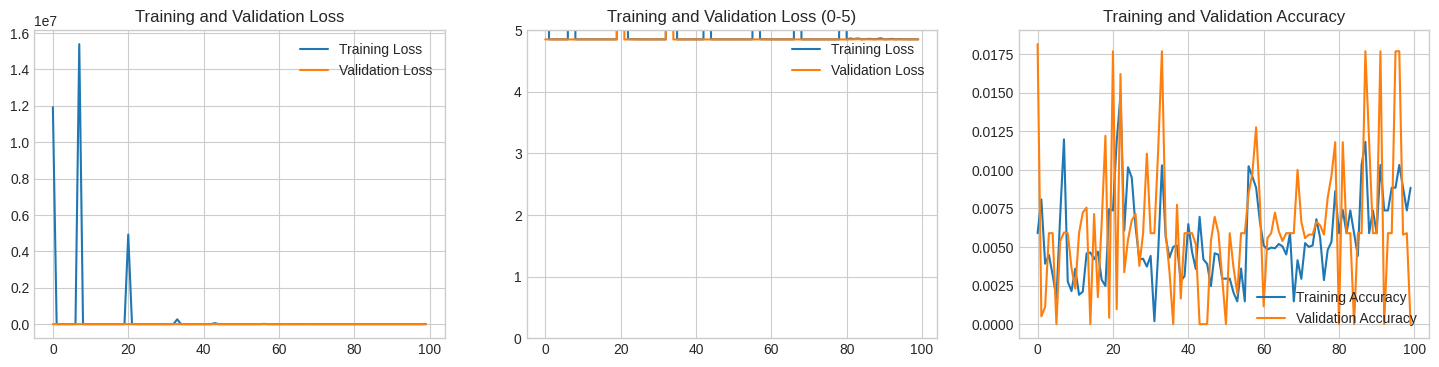

In [22]:
epochs = 100
verbose = False
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 訓練データセットの反復
    for batch, labels_batch in train_dataset:
        train_step(batch, labels_batch, verbose)

    # 訓練の損失と精度を記録
    train_loss = train_loss_metric.result().numpy()
    train_accuracy = train_accuracy_metric.result().numpy()
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 検証データセットの評価
    for val_batch, val_labels_batch in val_dataset:
        val_step(val_batch, val_labels_batch)

    # 検証の損失と精度を記録
    val_loss = val_loss_metric.result().numpy()
    val_accuracy = val_accuracy_metric.result().numpy()
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # エポックごとの損失と精度を表示
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    print(f"Epoch {epoch + 1}: Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    if epoch >= 20 and (epoch + 1) % 10 == 0:  # 最初の20エポックはスキップし、10エポックごとにグラフを更新
        # プロット
        clear_output(wait=True)  # 既存のグラフをクリア
        plt.figure(figsize=(18, 4))  # グラフのサイズを調整

        # 訓練と検証の損失をプロット
        plt.subplot(1, 3, 1)  # 3つのサブプロットの1つ目
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        # 損失を0から5の区間でプロット
        plt.subplot(1, 3, 2)  # 3つのサブプロットの2つ目
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.ylim(0, 5)  # y軸の範囲を0から1に設定
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss (0-5)')

        # 訓練と検証の精度をプロット
        plt.subplot(1, 3, 3)  # 3つのサブプロットの3つ目
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.show()

    # メトリックのリセット
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    val_loss_metric.reset_states()
    val_accuracy_metric.reset_states()

# モデルの保存 (必要に応じて)
# two_tower_model.save('two_tower_model')